In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks

## SLI Benchmarks

## HPC Benchmark - weak scaling

Conn. Creation (min)                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e)   
N_VP                                                                  
36                  47.47                69.92                56.66   
72                  47.47                72.80                56.59   
144                 47.41                72.66                57.06   
288                 47.67                71.04                57.37   
576                 47.48                71.13                58.23   
1152                47.59                  NaN                  NaN   

                          Conn. Exchange (min)                       \
Case NEST RNG (9443a8907)            NEST 2.20 NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                  75.49                51.06                79.20   
72                  74.07                54.56                81.26   
144                 71.16                56.86                81.98   
288                 72.05                63.50                84.68   
576                 74.76                79.77                89.41   
1152                73.66               108.10                  NaN   

                                               Conn. Total  \
Case NEST 3.0 (a641eec1e) NEST RNG (9443a8907)   NEST 2.20   
N_VP                                                         
36                  77.80                78.70      100.88   
72                  80.93                81.15      106.29   
144                 80.88                85.74      108.38   
288                 85.66                85.07      113.49   
576                 89.80                90.94      131.74   
1152                  NaN                93.22      159.98   

                                                                     \
Case NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                 158.72               145.19               169.34   
72                 169.13               150.17               174.88   
144                166.18               149.15               172.75   
288                169.43               156.76               181.05   
576                176.24               161.55               188.11   
1152                  NaN                  NaN               192.40   

     Memory per VP                                            \
Case     NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST 3.0 (a641eec1e)   
N_VP                                                           
36        2.819082             2.886640             2.890740   
72        2.834828             2.892702             2.893303   
144       2.908171             2.978537             2.980969   
288       2.913480             2.983866             2.983796   
576       3.051638             3.074016             3.068073   
1152      3.395655                  NaN                  NaN   

                          Simulation time                       \
Case NEST RNG (9443a8907)       NEST 2.20 NEST 3.0 (8f5a5fc1e)   
N_VP                                                             
36               2.886351          191.81               203.83   
72               2.889157          199.87               211.11   
144              2.979875          199.12               217.54   
288              2.983984          212.72               230.29   
576              3.074798          228.70               242.58   
1152             3.451043          267.55                  NaN   

                                                
Case NEST 3.0 (a641eec1e) NEST RNG (9443a8907)  
N_VP                                            
36                 204.21               234.33  
72                 207.42               242.69  
144                211.14               244.87  
288                225.03               253.43  
576        

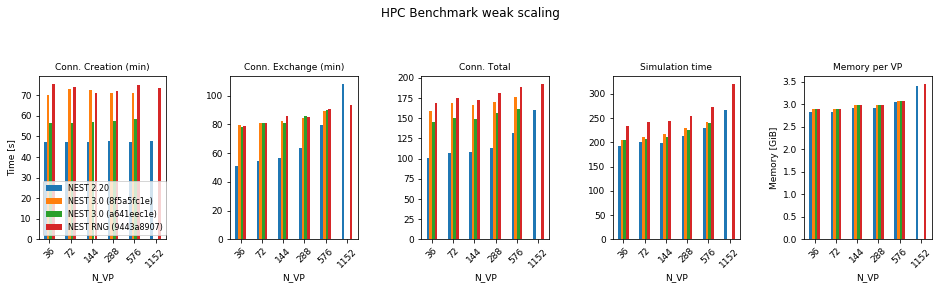

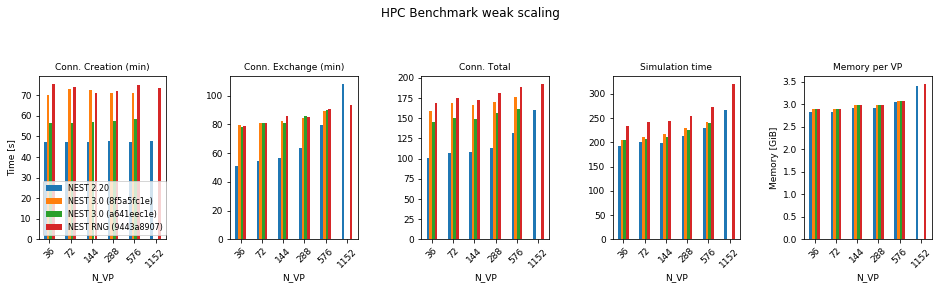

In [21]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)

hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv')
hpc_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(hpc_3_a6)
hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv')
hpc_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_8f)

hpc_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint.csv')
hpc_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_rng)

hpc = pd.concat([hpc_220, hpc_3_a6, hpc_3_8f, hpc_rng])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/rng/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')
hpc_p = plot_compare(hpc, 'figures/rng/hpc_benchmark_weak_scaling.png', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

hpc_p

## HPC Benchmark - strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.61                 0.93                 0.95   
12                        0.30                 0.48                 0.49   
24                        0.15                 0.24                 0.26   
48                        0.08                 0.13                 0.13   
96                        0.04                 0.07                 0.07   
192                       0.02                  NaN                 0.04   
384                       0.01                  NaN                 0.02   
768                       0.00                  NaN                 0.02   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                         0.68                 1.13                 1.20   
12                        0.47                 0.63                 0.65   
24                        0.31                 0.35                 0.36   
48                        0.29                 0.29                 0.24   
96                        0.16                 0.15                 0.18   
192                       0.18                  NaN                 0.13   
384                       0.20                  NaN                  NaN   
768                       0.18                  NaN                 0.28   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
6                1.48                 2.31                 2.52   
12               0.80                 1.23                 1.34   
24               0.49                 0.68                 0.76   
48               0.82                 0.50                 0.46   
96               0.61                 0.29                 0.32   
192              0.88                  NaN                 0.21   
384              0.94                  NaN                  NaN   
768              0.71                  NaN                 0.33   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
6                0.635518             1.097183             1.083729   
12               0.540298             0.994475             0.979556   
24               0.461600             0.925828             0.924947   
48               0.760461             1.118091             0.839632   
96               0.372274             0.836309             0.831420   
192              0.346288                  NaN             0.789341   
384              0.348532                  NaN                  NaN   
768              0.347982                  NaN             0.779703   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
6                    6.69                 7.38                 9.11  
12                   3.83                 4.02                 4.84  
24                   2.42                 2.27                 2.67  
48                   8.71                 6.01                 1.74  
96                   2.10                 1.82                 1.75  
192                  2.74                  NaN                 1.78  
384                  3.36                  NaN                  NaN  
768                  3.62                  NaN                 2.23

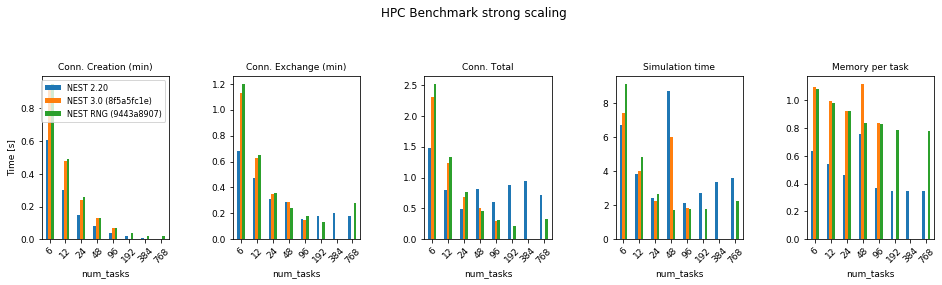

In [23]:
hpc_strong_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_strong_scaling.csv')
hpc_strong_220['Case'] = ['NEST 2.20'] * len(hpc_strong_220)

hpc_3_strong_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_strong_scaling.csv')
hpc_3_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_3_strong_8f)

hpc_strong_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_strong_scaling.csv')
hpc_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_strong_rng)

hpc_strong = pd.concat([hpc_strong_220, hpc_3_strong_8f, hpc_strong_rng])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/rng/hpc_benchmark_strong_scaling.png',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC Benchmark strong scaling')

hpc_strong_p

## HPC Benchmark `fixed_outdegree` - weak scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                 108.81               121.68                15.58   
72                 198.20               222.30                16.55   
144                376.34               423.44                16.55   
288                729.41               824.50                17.35   
576               1427.70                  NaN                18.85   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                  16.56               126.76               141.59   
72                  17.44               219.49               244.10   
144                 17.08               396.50               445.38   
288                 18.26               758.01               858.43   
576                   NaN              1471.50                  NaN   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               0.845622             0.847773                34.24   
72               0.862995             0.858446                33.28   
144              0.871180             0.870049                33.59   
288              0.939450             0.925291                35.88   
576              1.101778                  NaN                40.65   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36                  40.39  
72                  39.04  
144                 38.85  
288                 40.77  
576                   NaN

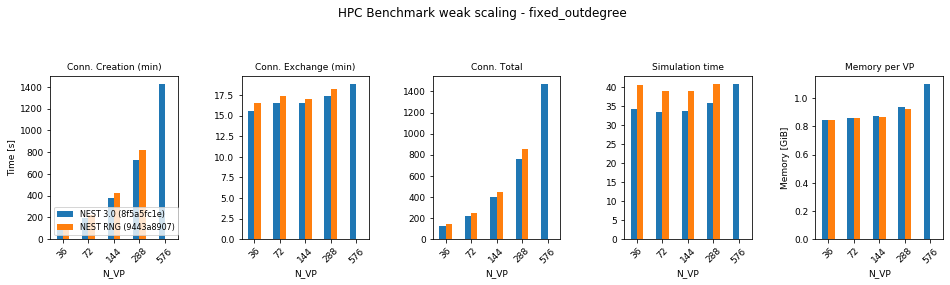

In [24]:
hpc_out_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_out.csv')
hpc_out_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_out_8f)

hpc_out_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_out.csv')
hpc_out_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_out_rng)

hpc_out = pd.concat([hpc_out_8f, hpc_out_rng])

hpc_out = calculate_T_conn_and_memory(hpc_out)
hpc_out_p = plot_compare(hpc_out, 'figures/rng/hpc_benchmark_weak_scaling_out.png', legend_loc='lower left',
                         title='HPC Benchmark weak scaling - fixed_outdegree')

hpc_out_p

## HPC Benchmark `fixed_total_number` - weak scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36                  20.95                21.30                20.22   
72                  20.39                21.57                21.19   
144                 20.46                21.67                20.86   
288                 19.75                21.62                22.63   
1152                  NaN                45.80                  NaN   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36                  20.26                42.63                46.89   
72                  20.32                45.87                45.33   
144                 21.60                45.18                48.00   
288                 23.24                47.25                50.34   
1152                  NaN                  NaN                  NaN   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               0.823975             0.829381                36.83   
72               0.830660             0.831997                32.90   
144              0.849058             0.849175                34.20   
288              0.915606             0.913552                35.93   
1152                  NaN                  NaN                  NaN   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36                  42.15  
72                  38.79  
144                 38.71  
288                 40.92  
1152                  NaN

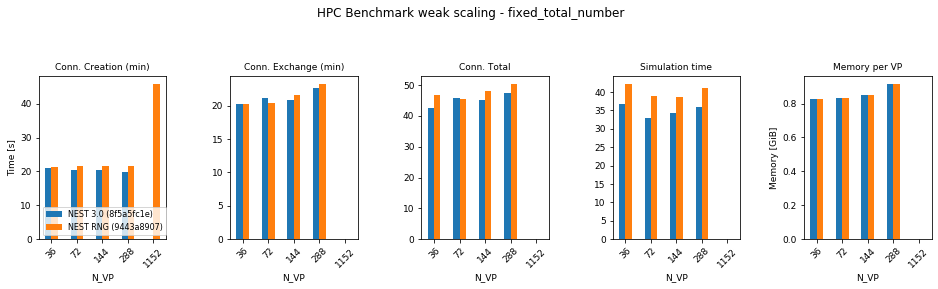

In [25]:
hpc_tot_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint_tot.csv')
hpc_tot_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hpc_tot_8f)

hpc_tot_rng = pd.read_csv('results/rng/hpc_benchmark_rng_9443a8907_daint_tot.csv')
hpc_tot_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hpc_tot_rng)

hpc_tot = pd.concat([hpc_tot_8f, hpc_tot_rng])

hpc_tot = calculate_T_conn_and_memory(hpc_tot)
hpc_tot_p = plot_compare(hpc_tot, 'figures/rng/hpc_benchmark_weak_scaling_tot.png', legend_loc='lower left',
                         title='HPC Benchmark weak scaling - fixed_total_number')

hpc_tot_p

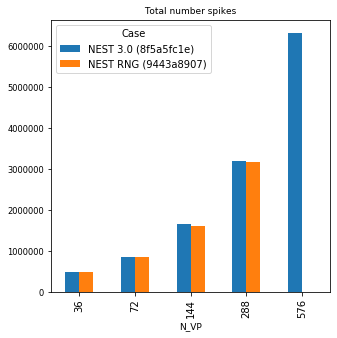

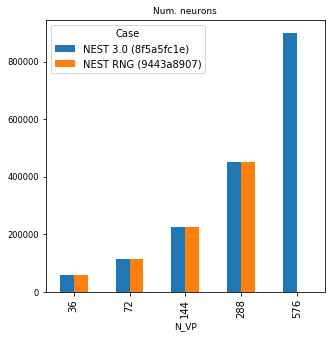

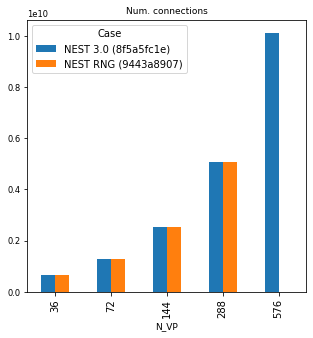

In [8]:
hpc_rule = pd.concat([hpc_out, hpc_tot])

hpc_rule_p = pd.pivot_table(hpc_rule, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

hpc_rule_p['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
hpc_rule_p['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
hpc_rule_p['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## Python Benchmarks

## Population model - with simulation, weak scaling

0    0
1    0
2    0
3    0
4    0
5    0
0    0
1    0
2    0
3    0
4    0
5    0
Name: N_spks_sum, dtype: int64


Conn. Creation (min)                      Conn. Exchange (min)  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36              47.274928            48.470755            49.880384   
72              68.480578            70.500262            64.193010   
144             87.065022            88.949677            67.351998   
288            123.370981           124.134125            71.028175   
576            200.750428           200.855462           120.947394   
1152           352.575103           349.540493            89.643744   

                                   Conn. Total                       \
Case NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36              48.779330           107.008492           110.685591   
72              62.490629           141.911463           149.264497   
144             63.568594           165.734244           168.632432   
288             69.486607           206.770948           206.607486   
576             72.265913           334.067568           290.703984   
1152           136.419465           459.256482           507.138250   

            Memory per VP                           Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
N_VP                                                                  
36               2.333985             2.323274            30.894495   
72               3.091078             3.029287            38.788532   
144              3.237555             3.112640            64.797525   
288              3.371930             3.371703           167.480526   
576              3.373050             3.373023           125.315002   
1152             3.431286             3.434789           141.806240   

                           
Case NEST RNG (9443a8907)  
N_VP                       
36              80.386662  
72              80.574523  
144             80.773935  
288            174.201580  
576            232.462918  
1152           199.295813

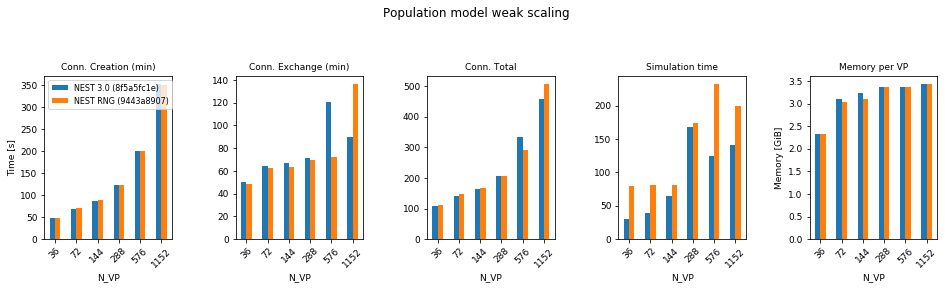

In [26]:
pop_220 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
pop_220['Case'] = ['NEST 2.20'] * len(pop_220)

pop_3_8f = pd.read_csv('results/population_model_3_0_8f5a5fc1e_daint.csv')
pop_3_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(pop_3_8f)
pop_3_a6 = pd.read_csv('results/population_model_3_0_a641eec1e_daint_in_scale4.csv')
pop_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(pop_3_a6)

pop_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint.csv')
pop_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_rng)

pop = pd.concat([pop_3_8f, pop_rng])

pop = calculate_T_conn_and_memory(pop)
pop_p = plot_compare(pop, 'figures/rng/population_model_weak_scaling.png', legend_loc='upper left',
                     title='Population model weak scaling')

print(pop['N_spks_sum'])

pop_p

## Population model - with simulation, strong scaling

Conn. Creation (min)                      Conn. Exchange (min)  \
Case      NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
num_tasks                                                                  
12                   85.541871            88.139236            80.091807   
24                   54.366502            55.578962            41.351880   
48                   38.561891            38.962357            21.927554   
96                   31.326425            31.345915            12.732042   
192                  27.528834            27.369665             8.197193   
384                  25.466670            25.189880             6.730836   
768                  24.167019            23.844734             3.802465   

                                        Conn. Total                       \
Case      NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
12                   76.745035           177.825204           180.555321   
24                   39.500992           103.232310           103.071377   
48                   22.690205            64.370464            66.994738   
96                   12.441035            46.081574            46.630359   
192                   8.582129            37.057137            37.730863   
384                   6.734804            33.579323            33.202596   
768                   4.009909            29.445947            29.077293   

               Memory per task                           Simulation time  \
Case      NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907) NEST 3.0 (8f5a5fc1e)   
num_tasks                                                                  
12                   22.206545            21.824729            50.482684   
24                   12.874696            12.303752            38.683829   
48                    7.999607             7.965570            33.560266   
96                    5.381572             5.396871            26.828480   
192                   4.439219             4.466074            49.814960   
384                   3.651798             3.660821            41.328887   
768                   2.824413             2.833563            30.294724   

                                
Case      NEST RNG (9443a8907)  
num_tasks                       
12                  102.921283  
24                   48.921535  
48                   50.323684  
96                   39.558214  
192                  54.650863  
384                  43.173785  
768                  32.243013

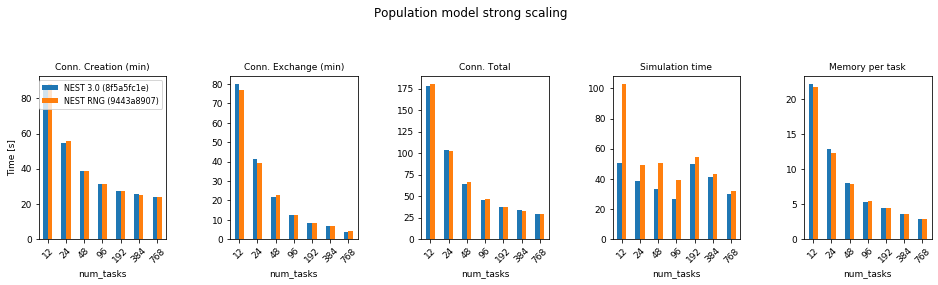

In [33]:
pop_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
pop_strong_220['Case'] = ['NEST 2.20'] * len(pop_strong_220)

pop_3_strong_8f = pd.read_csv('results/population_model_3_0_8f5a5fc1e_daint_strong_scaling.csv')
pop_3_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(pop_3_strong_8f)

pop_strong_rng = pd.read_csv('results/rng/population_model_rng_9443a8907_daint_strong_scaling.csv')
pop_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(pop_strong_rng)

pop_strong = pd.concat([pop_3_strong_8f, pop_strong_rng])

pop_strong = calculate_T_conn_and_memory(pop_strong)
pop_strong['Memory per task'] = (pop_strong['VSize_sum']/pop_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
pop_strong_p = plot_compare(pop_strong, 'figures/rng/population_model_strong_scaling.png',
                            values=values, index='num_tasks', plot_T_sim=True,
                            legend_loc='upper right',
                            title='Population model strong scaling')

pop_strong_p

## Multi-Area Model - weak scaling

Conn. Creation (min)                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36             104.711977            97.210136           123.469613   
72             146.223853            98.972858           124.991133   
144            231.737406           102.484994           128.961804   
288            406.488460           107.972112           139.087053   
576                   NaN           112.941850           150.907269   
1152                  NaN           148.266234           180.884189   

     Conn. Exchange (min)                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
N_VP                                                                  
36              32.292425            51.020458            51.149883   
72              33.331373            51.664472            51.939865   
144             34.721757            53.588018            52.918925   
288             39.016208            55.007008            53.199995   
576                   NaN            56.512569            55.355026   
1152                  NaN            59.218235            58.696019   

     Conn. Total                                           Memory per VP  \
Case   NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)     NEST 2.20   
N_VP                                                                       
36    137.004547           148.230715           174.619519      2.623531   
72    179.555844           150.637492           176.931092      2.662962   
144   266.460711           156.073213           181.880893      2.724151   
288   445.505543           162.979835           192.287163      2.900609   
576          NaN           169.454840           206.262467           NaN   
1152         NaN           207.486028           239.580448           NaN   

                                               Simulation time  \
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)       NEST 2.20   
N_VP                                                             
36               2.658186             2.657749      101.550807   
72               2.738548             2.737432       96.687742   
144              2.790624             2.802477      175.965840   
288              2.897943             2.904642       43.724532   
576              2.710373             2.716914             NaN   
1152             2.965120             2.964203             NaN   

                                                
Case NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
N_VP                                            
36             585.367757           620.836287  
72             600.732289           653.586833  
144            286.678333           729.767947  
288            173.648644           243.125916  
576            209.502138           276.955336  
1152           295.472016           361.030544

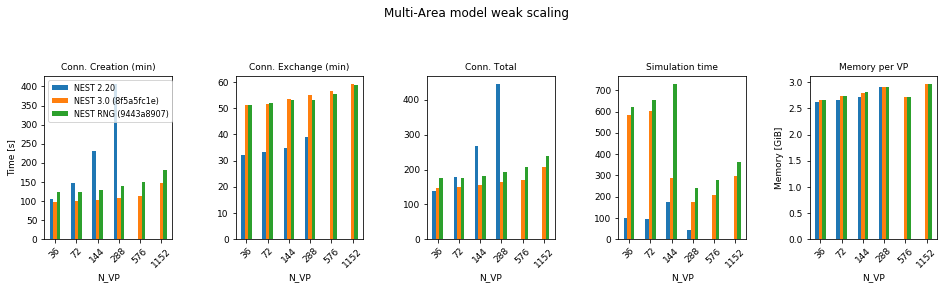

In [28]:
MAM_220 = pd.read_csv('results/multi-area_model_2_20_new_daint.csv')
MAM_220['Case'] = ['NEST 2.20'] * len(MAM_220)

MAM_8f = pd.read_csv('results/multi-area_model_3_0_8f5a5fc1e_sim2000_daint.csv')
MAM_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(MAM_8f)
                     
MAM_rng = pd.read_csv('results/rng/multi-area_model_rng_9443a8907_sim2000_daint.csv')
MAM_rng['Case'] = ['NEST RNG (9443a8907)'] * len(MAM_rng)

MAM = pd.concat([MAM_220, MAM_8f, MAM_rng])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/rng/multi-area_model_weak_scaling.png', legend_loc='upper left',
                     title='Multi-Area model weak scaling')
MAM_p

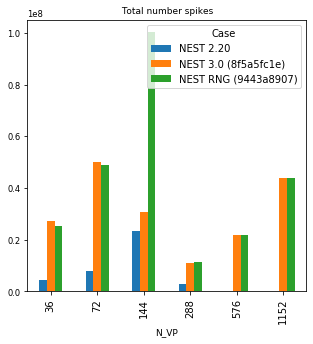

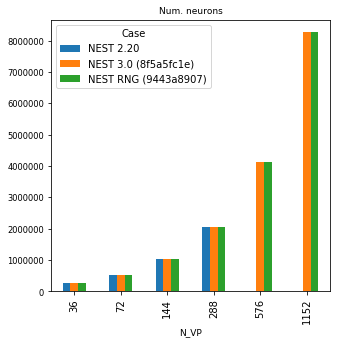

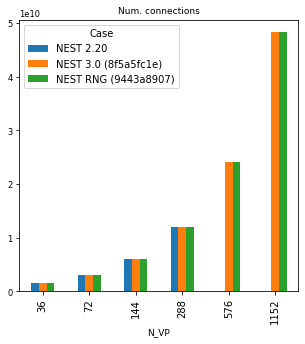

In [53]:
MAM_s = pd.pivot_table(MAM, index='N_VP', columns='Case', values=['N_spks_sum', 'N_nrns', 'N_conns_sum'])

MAM_s['N_spks_sum'].plot(kind='bar', title="Total number spikes", figsize=(5,5))
MAM_s['N_nrns'].plot(kind='bar', title="Num. neurons", figsize=(5,5))
MAM_s['N_conns_sum'].plot(kind='bar', title="Num. connections", figsize=(5,5))

## MAM - strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
192                 656.739572            81.700655           108.813451   
288                 647.955257            70.719509           103.166390   
384                        NaN            67.595746           103.399942   
480                 642.865273            65.113531           104.304120   
576                 642.099864            61.954762           106.132354   
672                 640.462307                  NaN           108.523082   
768                 640.647660            60.821798           111.065309   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
192                  27.460267            30.220250            29.586955   
288                  21.280975            21.833310            21.376817   
384                        NaN            17.769392            17.458683   
480                  15.629361            15.365957            15.040238   
576                  13.862626            14.189873            13.862624   
672                  12.313328                  NaN            13.173794   
768                  11.422459            11.616562            11.799357   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
192        684.200660           111.921230           138.400545   
288        669.237295            92.553204           124.543357   
384               NaN            85.365550           120.858787   
480        658.496879            80.484431           119.344553   
576        655.966974            76.144971           119.995186   
672        652.782241                  NaN           121.697101   
768        652.083801            72.442473           122.864853   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
192             10.806041            10.329274            10.340525   
288              7.684051             7.351273             7.333227   
384                   NaN             6.397775             6.402108   
480              5.874357             5.717255             5.717239   
576              5.298488             5.143122             5.141450   
672              4.921475                  NaN             4.741472   
768              4.536059             4.457327             4.451603   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
192            149.841436           169.081914           193.736421  
288            202.562903           158.810847           169.516007  
384                   NaN           125.249515           147.609027  
480            216.793543           161.996467           200.295184  
576            183.220357           146.355706           151.096922  
672            209.088735                  NaN           191.325485  
768            183.525031           143.517147           175.483609

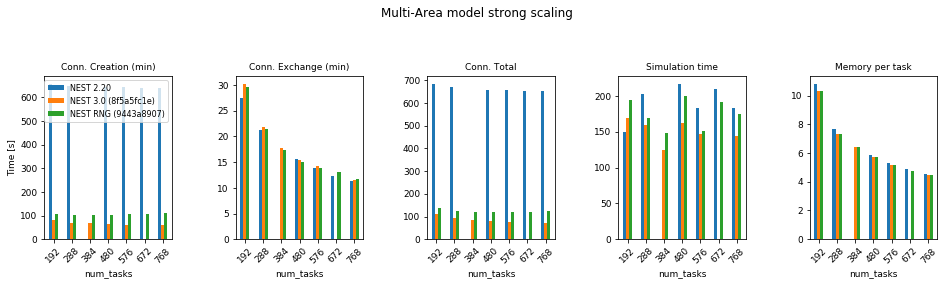

In [35]:
MAM_strong_220 = pd.read_csv('results/multi-area_model_2_20_daint_strong_scaling.csv')
MAM_strong_220['Case'] = ['NEST 2.20'] * len(MAM_strong_220)

MAM_strong_8f = pd.read_csv('results/multi-area_model_3_0_8f5a5fc1e_daint_strong_scaling.csv')
MAM_strong_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(MAM_strong_8f)

MAM_strong_rng = pd.read_csv('results/rng/multi-area_model_rng_9443a8907_daint_strong_scaling.csv')
MAM_strong_rng['Case'] = ['NEST RNG (9443a8907)'] * len(MAM_strong_rng)

MAM_strong = pd.concat([MAM_strong_220, MAM_strong_8f, MAM_strong_rng])

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
MAM_strong['Memory per task'] = (MAM_strong['VSize_sum']/MAM_strong['num_tasks'])*1024/1024**3
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p = plot_compare(MAM_strong, 'figures/rng/multi-area_model_strong_scaling.png',
                            values=values, index='num_tasks', plot_T_sim=True,
                            legend_loc='upper right',
                            title='Multi-Area model strong scaling')

MAM_strong_p

## Hill tonini - Strong scaling

Conn. Creation (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                     3.369209             0.538458             0.699559   
12                    2.424937             0.343281             0.416297   
24                    1.863762             0.236212             0.271865   
48                    1.672143                  NaN                  NaN   
96                    1.589094             0.142444                  NaN   
192                   3.329755             0.115095             0.124492   
384                   1.560687             0.103625             0.105825   
768                   3.677774             0.095469             0.099358   

          Conn. Exchange (min)                                            \
Case                 NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                                  
6                     0.344653             0.377994             0.388894   
12                    0.328508             0.422996             0.439749   
24                    0.278032             0.333048             0.330789   
48                    0.188323                  NaN                  NaN   
96                    0.149609             0.225625                  NaN   
192                   0.116746             0.189043             0.219221   
384                   0.129887             0.218439             0.211044   
768                   0.185456             0.318350             0.328166   

          Conn. Total                                            \
Case        NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                         
6            3.853066             0.999555             1.146480   
12           2.901895             0.821878             0.880836   
24           2.281637             0.592714             0.669724   
48           2.019383                  NaN                  NaN   
96           1.900187             0.526999                  NaN   
192          3.600970             0.386075             0.433013   
384          1.859231             0.494050             0.462581   
768          4.055079             0.595469             0.591953   

          Memory per task                                            \
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)   
num_tasks                                                             
6                1.346101             1.985830             1.970062   
12               1.298610             1.930811             1.898035   
24               1.256289             1.887716             1.879395   
48               1.120590                  NaN                  NaN   
96               1.015988             1.718893                  NaN   
192              1.013022             1.685470             1.683965   
384              1.042091             1.712345             1.704873   
768              1.038055             1.707480             1.705924   

          Simulation time                                            
Case            NEST 2.20 NEST 3.0 (8f5a5fc1e) NEST RNG (9443a8907)  
num_tasks                                                            
6                1.442217             1.331084             1.331200  
12               0.866928             0.798856             0.741638  
24               0.613624             0.586140             0.601088  
48               0.398614                  NaN                  NaN  
96               0.357492             0.448050                  NaN  
192              0.308830             0.208081             0.227185  
384              0.286875             0.283909             0.295910  
768              0.325538             0.371939             0.370928

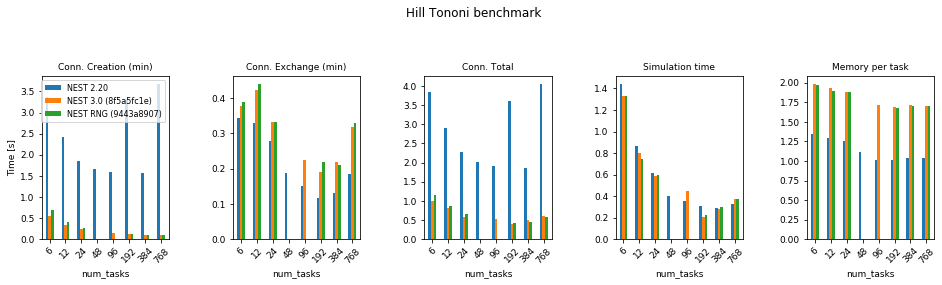

In [34]:
hill_tononi_220 = pd.read_csv('results/hill_tononi_2_20_daint.csv')
hill_tononi_220['Case'] = ['NEST 2.20'] * len(hill_tononi_220)
hill_tononi_3 = pd.read_csv('results/hill_tononi_3_0_0a6bac389_daint.csv')
hill_tononi_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(hill_tononi_3)

hill_tononi_8f = pd.read_csv('results/hill_tononi_3_0_8f5a5fc1e_daint.csv')
hill_tononi_8f['Case'] = ['NEST 3.0 (8f5a5fc1e)'] * len(hill_tononi_8f)
hill_tononi_rng = pd.read_csv('results/rng/hill_tononi_9443a8907_daint.csv')
hill_tononi_rng['Case'] = ['NEST RNG (9443a8907)'] * len(hill_tononi_rng)

hill_tononi = pd.concat([hill_tononi_220, hill_tononi_8f, hill_tononi_rng])

hill_tononi = calculate_T_conn_and_memory(hill_tononi)
hill_tononi['Memory per task'] = (hill_tononi['VSize_sum']/hill_tononi['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hill_tononi_p = plot_compare(hill_tononi, 'figures/rng/hill_tononi.png', values=values,
                             index='num_tasks', legend_loc='upper right',
                             title='Hill Tononi benchmark')

hill_tononi_p